In [1]:
import cvxpy as cvx
import numpy as np
import scipy as sc
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import Isomap
from sklearn.preprocessing import normalize

In [2]:
np.random.seed(1)

## Embedding procedure

In [3]:
# Embedding of a point cloud in R^d by pairwise distances
#
# p_dist -- matrix of pairwise distances
#
# d -- dimension of the embedding
#
# eps -- radius of localization
#
# C = min{2/pi, 2*reach(M) / int_diam(M)} -- parameter of the procedure
# int_diam(M) -- intrinsic diameter of M

def make_embedding(p_dist, d, eps, C):
    
    # Semi-definite convex program
    
    # squared distances
    sD = p_dist**2
    
    # variables
    K = cvx.Variable((n,n), symmetric=True)
    t = cvx.Variable(1)

    # objective
    obj = cvx.Minimize(t)

    # constraints
    constraints = [K >> 0]

    for i in range(n):
        for j in range(i+1, n):
        
            constraints += [K[i, i] + K[j,j] - 2*K[i,j] >= C**2 * sD[i,j]]
            
            if (p_dist[i, j] < eps):

                constraints += [K[i, i] + K[j,j] - 2*K[i,j] - sD[i, j] <= t * sD[i, j]]
                constraints += [K[i, i] + K[j,j] - 2*K[i,j] - sD[i, j] >= -t * sD[i, j]]

    print('Total number of constraints:', len(constraints))

    
    # Solve the problem of convex SDP with given
    # objective and constraints
    prob = cvx.Problem(obj, constraints)
    
    # value of the target functional
    result = prob.solve(solver='SCS')
    #result = prob.solve(solver='SCS', max_iters=100, eps=1e-3)

    # matrix of pairwise distances
    K_opt = np.array(K.value)
    print(K_opt.shape)
    
    # value of the target functional
    t_opt = np.array(t.value)
    
    # recover the embedding from the Gram matrix
    
    # perform SVD
    u, sigma, v = np.linalg.svd(K_opt, full_matrices=False)

    # embedding
    Y = u[:, :d] @ np.diag(sigma[:d]**0.5)
    
    return Y, t_opt

## Segment example

In [4]:
# Generate data

# number of samples
n = 100

# noise
noise_level = 0

# generate points on [0, 1]
X = np.linspace(0, 1, n).reshape(-1, 1)
print(X.shape)

# compute pairwise Euclidean distances
p_dist = squareform(pdist(X))

# print the diameter
D = np.max(p_dist)
print('D =', D)

(100, 1)
D = 1.0


In [5]:
# Perform the embedding

# parameters of the procedure
d = 2
eps = 0.2

Y, t = make_embedding(p_dist, d=d, eps=eps, C=2/np.pi)

Total number of constraints: 8371
(100, 100)


In [6]:
# print the value of the target functional
print('Value of the target functional:', t)

# compare the pairwise distances of the embedding
# with the initial ones

p_dist_new = squareform(pdist(Y))

print('Average difference between pairwise distances:',\
      np.linalg.norm((p_dist_new - p_dist) / (p_dist + np.eye(n)), ord='fro') / n)

Value of the target functional: [0.00020894]
Average difference between pairwise distances: 0.0008857561583766968


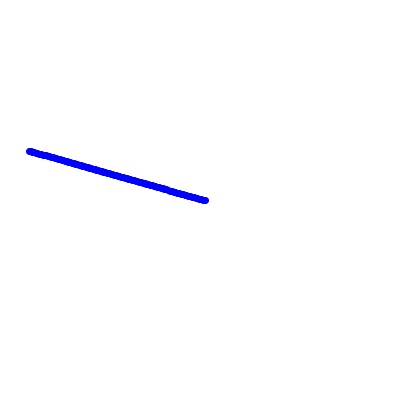

In [7]:
# Plot the manifold
%matplotlib inline

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Y[:, 0], Y[:, 1], 'bo')
ax.axis('off')
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, 0.5)

plt.show()

## Sphere example 1: points on the grid

In [8]:
# Generate data

# number of samples
n_1 = 10
n_2 = 10

n = n_1 * n_2

# points on a grid on unit sphere

# generate spherical coordinates
phi = np.linspace(0, 2 * np.pi, n_1+1)[:-1]
theta = np.linspace(0, np.pi, n_2 + 2)[1:-1]

# generate points on unit sphere

X = np.append(np.outer(np.cos(phi), np.sin(theta)).reshape(-1, 1),\
              np.outer(np.sin(phi), np.sin(theta)). reshape(-1, 1), axis=1)
X = np.append(X, np.outer(np.ones(np.size(phi)), np.cos(theta)).reshape(-1, 1), axis=1)

# compute pairwise distances on sphere
p_dist = np.real(np.lib.scimath.arccos(cosine_similarity(X)))

print(X.shape)

# print the diameter
D = np.max(p_dist)
print('D =', D)

(100, 3)
D = 3.141592653589793


In [9]:
# Perform the embedding

# parameters of the procedure
d = 3
eps = 0.6

Y, t = make_embedding(p_dist, d=d, eps=eps, C=2/np.pi)

Total number of constraints: 5911
(100, 100)


In [10]:
# print the value of the target functional
print('Value of the target functional:', t)


# compare the pairwise distances of the embedding
# with the initial ones

# compute approximate pairwise distances of the embedding
isomap = Isomap(n_neighbors=n-1, n_components=2)
isomap.fit(Y)
p_dist_new = isomap.dist_matrix_

print('Average difference between pairwise distances:', \
      np.linalg.norm((p_dist_new - p_dist) / (p_dist + np.eye(n)), ord='fro') / n)

Value of the target functional: [0.00058104]
Average difference between pairwise distances: 0.1370892050641273


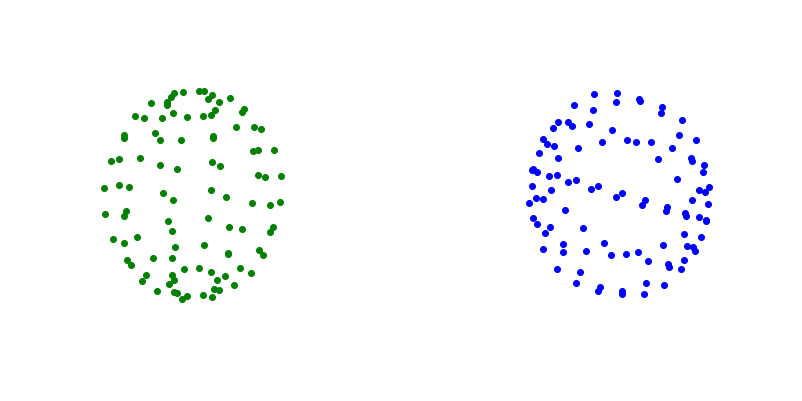

In [11]:
# Plot the points on sphere

%matplotlib inline

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121, projection='3d')
ax.plot(X[:, 0], X[:, 1], X[:, 2], 'go')
ax.axis('off')

ax = fig.add_subplot(122, projection='3d')
ax.plot(Y[:, 0], Y[:, 1], Y[:, 2], 'bo')
ax.axis('off')

plt.show()

## Sphere example 2: uniform distribution

In [12]:
# Generate data

# number of samples
n_1 = 10
n_2 = 10

n = n_1 * n_2

# points drawn from uniform distribution on unit sphere
X = np.random.randn(n, 3)
X = normalize(X)

# compute pairwise distances on sphere
sphere_p_dist = np.real(np.lib.scimath.arccos(cosine_similarity(X)))

print(X.shape)

# print the diameter
D = np.max(sphere_p_dist)
print('D =', D)

(100, 3)
D = 3.1133444106341464


In [13]:
# Perform the embedding

# parameters of the procedure
d=3
eps=0.6

Y, t = make_embedding(sphere_p_dist, d=d, eps=eps, C=2/np.pi)

Total number of constraints: 5789
(100, 100)


In [14]:
# print the value of the target functional
print('Value of the target functional:', t)

# compute approximate pairwise distances of the embedding
isomap = Isomap(n_neighbors=n-1, n_components=2)
isomap.fit(Y)
sphere_p_dist_new = isomap.dist_matrix_

# compare the pairwise distances of the embedding
# with the initial ones
print('Average difference between pairwise distances:', \
      np.linalg.norm((sphere_p_dist_new - sphere_p_dist) / (sphere_p_dist + np.eye(n)), ord='fro') / n)

Value of the target functional: [0.00031068]
Average difference between pairwise distances: 0.16117679447358793


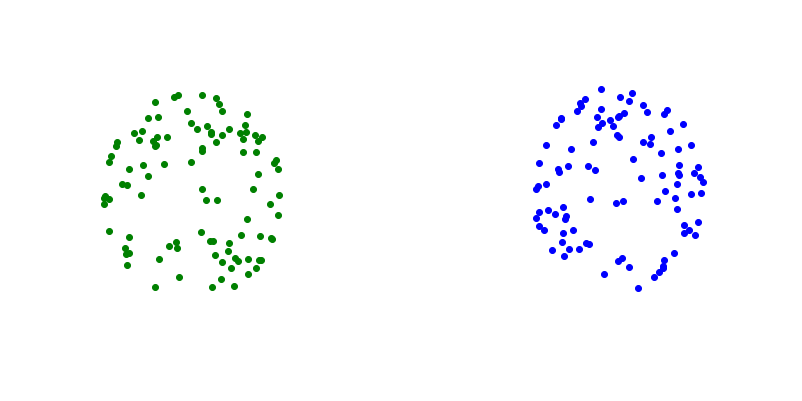

In [15]:
# Plot the points on sphere

%matplotlib inline

fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(121, projection='3d')
ax.plot(X[:, 0], X[:, 1], X[:, 2], 'go')
ax.axis('off')

ax = fig.add_subplot(122, projection='3d')
ax.plot(Y[:, 0], Y[:, 1], Y[:, 2], 'bo')
ax.axis('off')

plt.show()

## Swiss Roll example 1: Euclidean distances

In [16]:
# Generate data

# number of samples
n = 100

# noise
noise_level = 0

# data
X, t = make_swiss_roll(n_samples=n, noise=noise_level, random_state=1)

print(X.shape)

(100, 3)


In [17]:
# Compute pairwise distances

# Euclidean distances
p_dist = squareform(pdist(X))

In [18]:
# Perform the embedding

# parameters of the procedure
d = 3
eps = 3

Y, obj = make_embedding(p_dist, d=d, eps=eps, C=2 / np.pi)

Total number of constraints: 5079
(100, 100)


In [19]:
# print the value of the target functional
print('Value of the target functional:', obj)


# compare the pairwise distances of the embedding
# with the initial ones

p_dist_new = squareform(pdist(Y))

print('Average difference between pairwise distances:', \
      np.linalg.norm((p_dist_new - p_dist) / (p_dist + np.eye(n)), ord='fro') / n)

Value of the target functional: [-0.00014756]
Average difference between pairwise distances: 0.40094740966709325


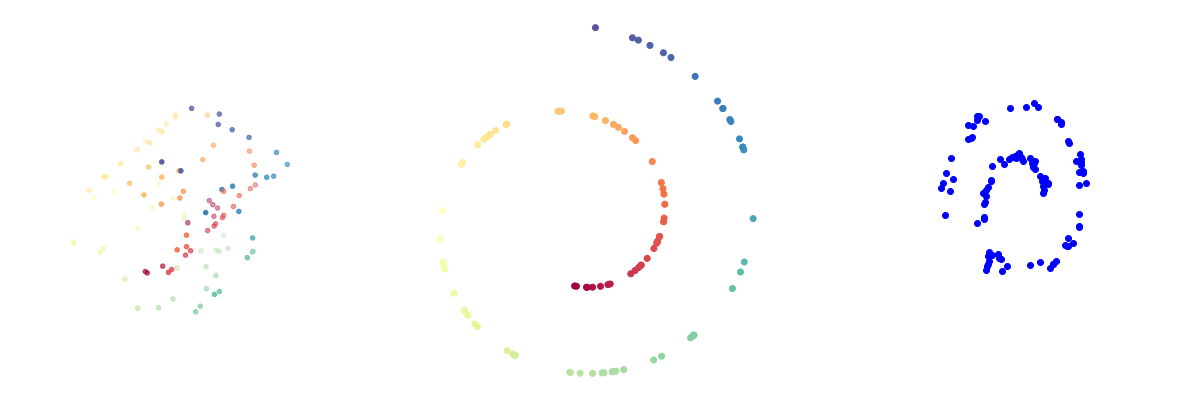

In [20]:
# Plot the manifold
%matplotlib inline

fig = plt.figure(figsize=(21, 7))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax.axis('off')

ax = fig.add_subplot(132)
ax.scatter(X[:, 0], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax.axis('off')

ax = fig.add_subplot(133, projection='3d')
ax.plot(Y[:, 0], Y[:, 1], Y[:, 2], 'bo')
ax.axis('off')

plt.show()

## Swiss Roll example 2: distances along manifold

In [21]:
# Distances along the Swiss Roll manifold

def dist_swiss_roll(X, t):
    
    Y = np.append(X[:, 1].reshape(-1, 1), t.reshape(-1, 1), axis=1)
    
    D = squareform(pdist(Y))
    
    return D

In [22]:
# Generate data

# number of samples
n = 100

# noise
noise_level = 0

# data
X, t = make_swiss_roll(n_samples=n, noise=noise_level, random_state=1)

print(X.shape)

(100, 3)


In [23]:
# Compute pairwise distances

# Distances along manifold
p_dist = dist_swiss_roll(X, t)

# print the diameter
D = np.max(p_dist)
print('D =', D)

D = 21.70354178109025


In [24]:
3.14 / 2 / 21.7

0.07235023041474654

In [25]:
# Perform the embedding

# parameters of the procedure
d = 2
eps = 3

Y, obj = make_embedding(p_dist, d=d, eps=eps, C=2/np.pi)

Total number of constraints: 6001
(100, 100)


In [26]:
# print the value of the target functional
print('Value of the target functional:', obj)


# compare the pairwise distances of the embedding
# with the initial ones

p_dist_new = squareform(pdist(Y))

print('Average difference between pairwise distances:', \
      np.linalg.norm((p_dist_new - p_dist) / (p_dist + np.eye(n)), ord='fro') / n)

Value of the target functional: [0.00025378]
Average difference between pairwise distances: 0.2847552999060454


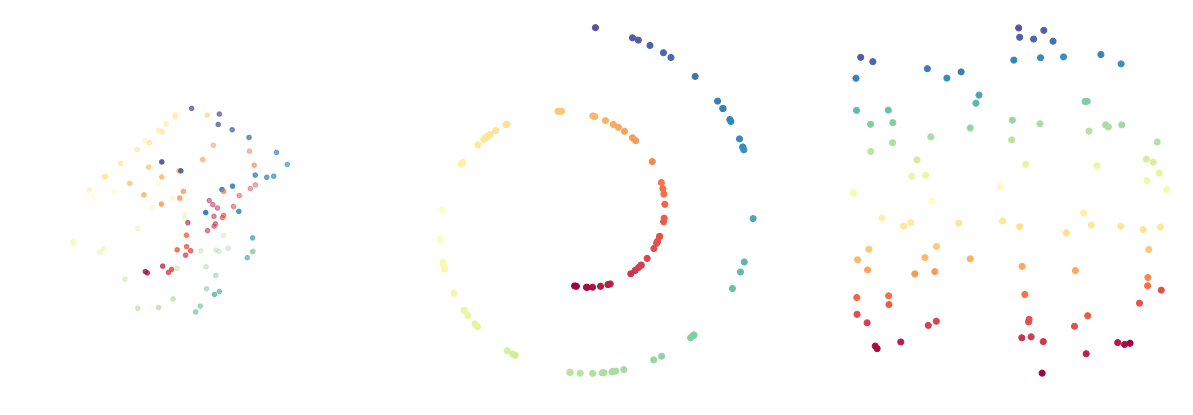

In [27]:
# Plot the manifold
%matplotlib inline

fig = plt.figure(figsize=(21, 7))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax.axis('off')

ax = fig.add_subplot(132)
ax.scatter(X[:, 0], X[:, 2], c=t, cmap=plt.cm.Spectral)
ax.axis('off')

ax = fig.add_subplot(133)
ax.scatter(Y[:, 0], Y[:, 1], c=t, cmap=plt.cm.Spectral)
plt.axis('off')

plt.show()